# Network analysis

### Imports

In [1]:
import os
import sys
import ast
import nbimporter
import import_ipynb
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
#sys.path.append('C:/Users/Administrator/Desktop/CreditGuard/ML model')
os.chdir('C:/Users/Administrator/Desktop/CreditGuard/ML model')
import model_functions as nb 

### Data preparation

In [2]:
df = nb.process_data()
df_binned = nb.bin_data(df)
df_encoded = nb.encode_data(df_binned)
df_encoded = df_encoded.drop(['state', 'street', 'city', 'm_state','m_street','m_city'], axis=1)

df_fraud = df_encoded[df_encoded['is_fraud'] == 1]
cc_fraud = df_fraud[df_fraud['fraud_type'] == 2]
b_fraud = df_fraud[df_fraud['fraud_type'] == 1]

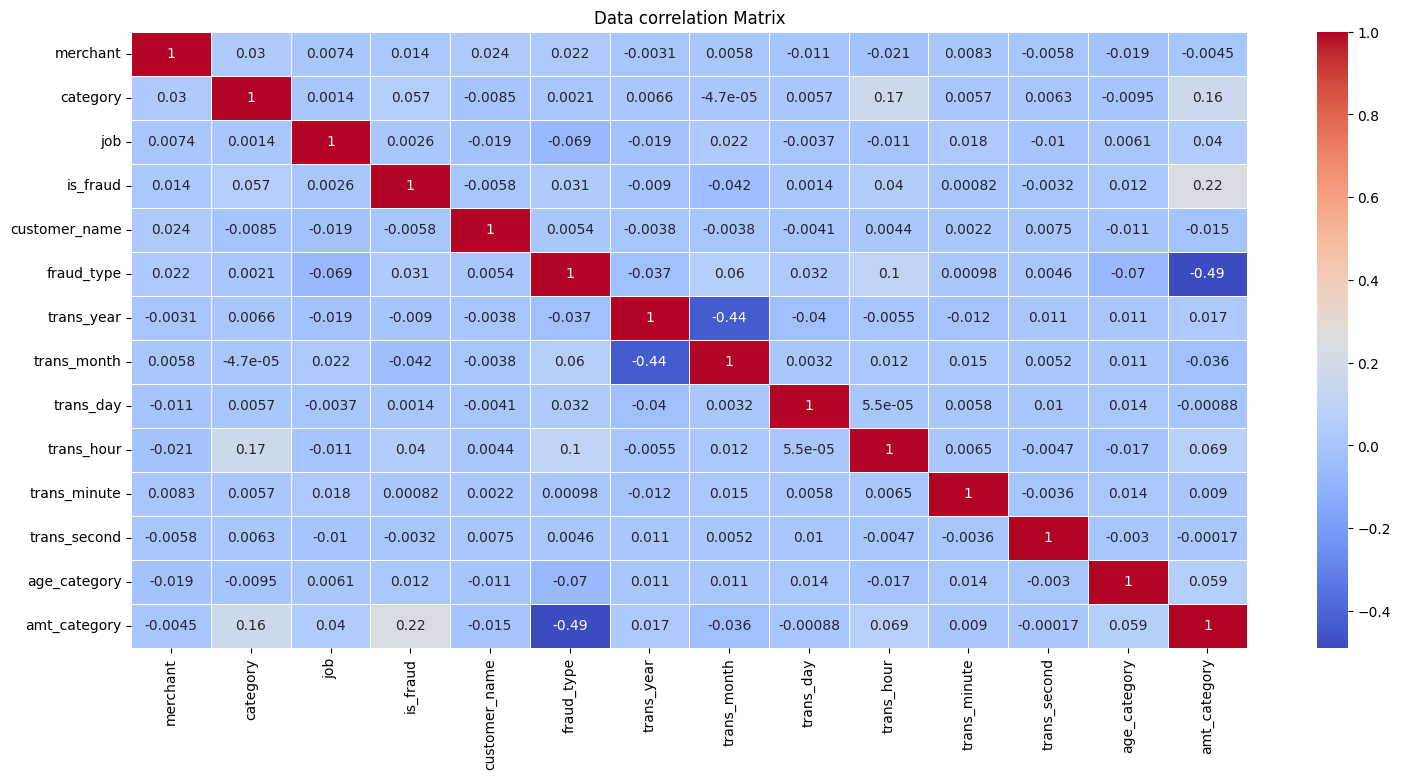

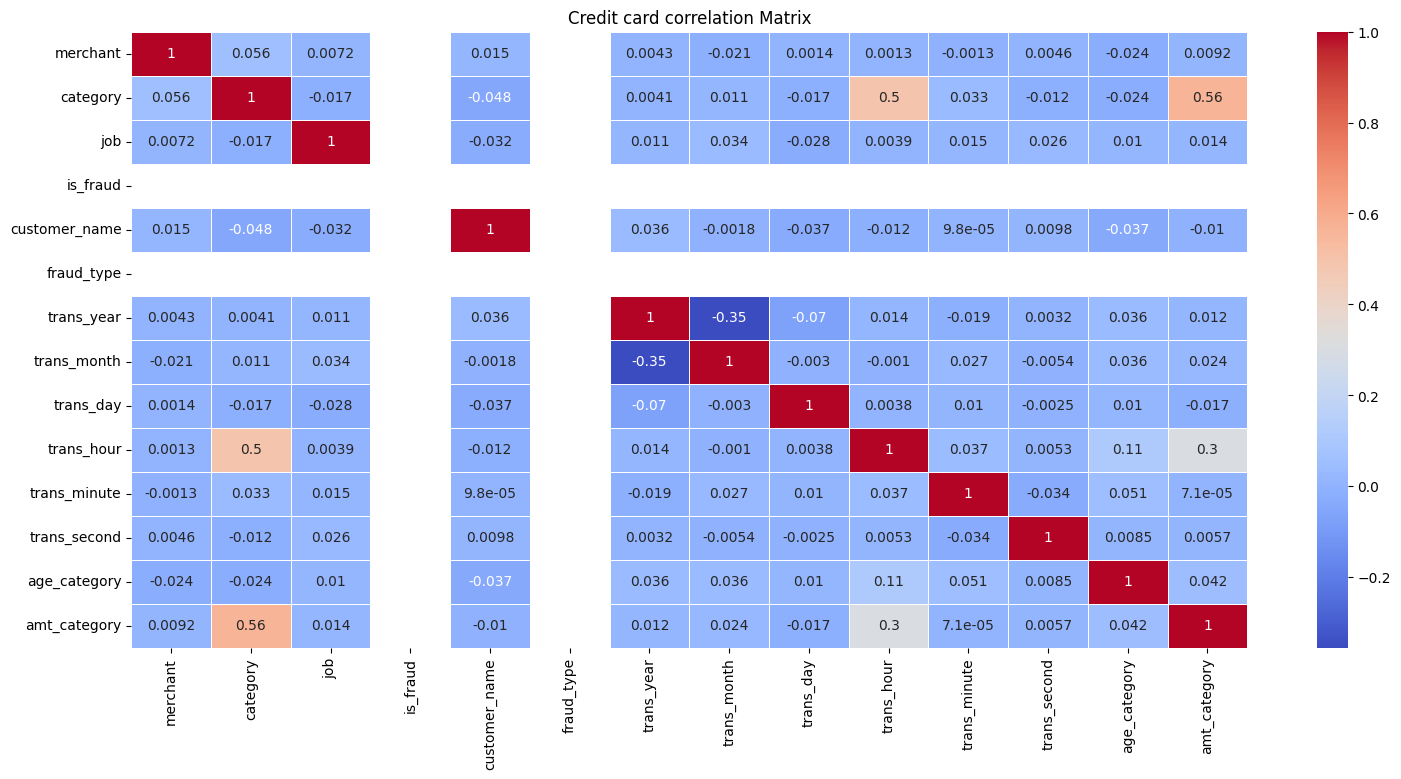

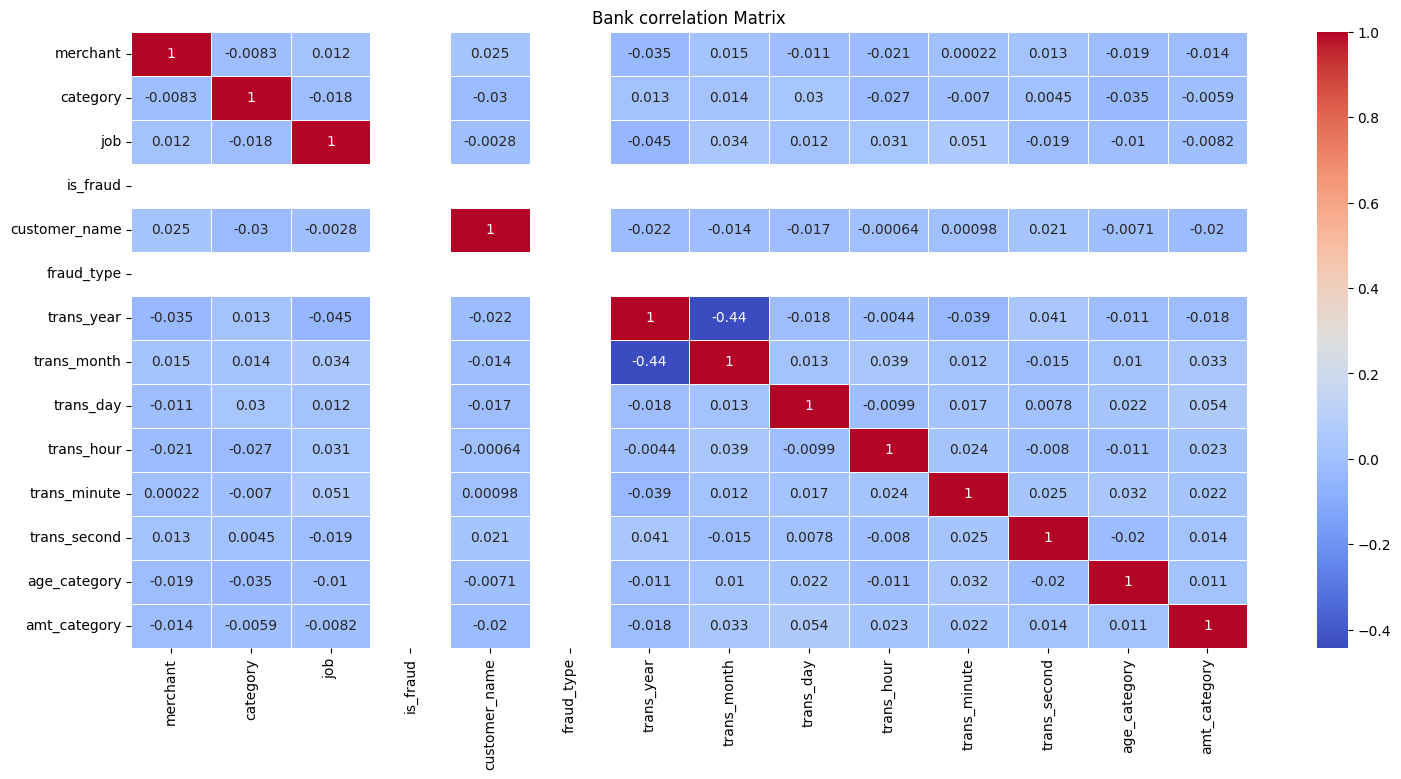

In [3]:
corr_cc_matrix = cc_fraud.corr()
corr_b_matrix = b_fraud.corr()
corr_encoded = df_encoded.corr()

plt.figure(figsize=(18, 8))
sns.heatmap(corr_encoded, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Data correlation Matrix')
plt.show()

plt.figure(figsize=(18, 8))
sns.heatmap(corr_cc_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Credit card correlation Matrix')
plt.show()

plt.figure(figsize=(18, 8))
sns.heatmap(corr_b_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Bank correlation Matrix')
plt.show()

Based on the correlation matrices displayed, it seems there is a relation between the category of the transaction that is marked as fraud and the amount of it, and this relation is more clearer in the correlation matrix of credit card fraud data, however in the bank fraud data it shows no correlation at all.

To understand the relations more, a network of those attributes will be constructed.

In [4]:
df_fraud = df[df['is_fraud'] == 1]
df_non_fraud = df[df['is_fraud'] == 0]
cc_fraud = df_fraud[df_fraud['fraud_type'] == 2]
b_fraud = df_fraud[df_fraud['fraud_type'] == 1]

### Functions

In [5]:
def draw_graph(G, name):
    sns.set_theme(style="whitegrid")
    
    plt.figure(figsize=(20, 7))
    pos = nx.spring_layout(G, k=0.15, iterations=20)  # k controls the distance between nodes
    
    # Draw nodes with gradient color based on degree
    node_colors = sns.color_palette("coolwarm", len(G.nodes))
    node_sizes = [(G.degree(n) * 100)+10 for n in G.nodes()]
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
    
    # Draw edges with transparency
    edges = nx.draw_networkx_edges(G, pos, alpha=0.4)
    
    # Add labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
    
    # Remove axis
    plt.axis('off')
    
    # Title and display
    plt.title(name, fontsize=20)
    plt.show()

In [6]:
def build_network_matrix(df, attribute1, attribute2):
    edges = []
    
    # Create a dictionary to store amounts by category
    category_amounts = {}
    
    for index, row in df.iterrows():
        # create an edge between the amount and the category
        edges.append((row[attribute1], row[attribute2]))
        
        # Add the amount category to the list of amounts for the specific category
        if row[attribute2] not in category_amounts:
            category_amounts[row[attribute2]] = []
        category_amounts[row[attribute2]].append(row[attribute1])
    
    # connect amounts to each other if they belong to the same category
    for att2, att1 in category_amounts.items():
        # Add edges between all pairs of amounts within the same category
        for i in range(len(att1)):
            for j in range(i + 1, len(att1)):
                edges.append((att1[i], att1[j]))
    
    return edges

In [7]:
def compute_graph_measures(graph):
    # degree centrality
    degree_centrality = nx.degree_centrality(graph)
    degcent_df = pd.DataFrame(degree_centrality, index=[0]).T
    degcent_df.columns = ['degree_centrality']
    degcent_df.sort_values('degree_centrality', inplace=True, ascending=False)
    
    # betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(graph)
    betcent_df = pd.DataFrame(betweenness_centrality, index=[0]).T
    betcent_df.columns = ['betweenness_centrality']
    betcent_df.sort_values('betweenness_centrality', inplace=True, ascending=False)
    
    # clustering coefficient
    clustering_coefficient = nx.clustering(graph)
    clustering_df = pd.DataFrame(clustering_coefficient, index=[0]).T
    clustering_df.columns = ['clustering_coefficient']
    clustering_df.sort_values('clustering_coefficient', inplace=True, ascending=False)
    
    graph_measures = {
        'degree_centrality': degcent_df,
        'betweenness_centrality': betcent_df,
        'clustering_coefficient': clustering_df
    }
    
    return graph_measures

### Category vs amount category networks

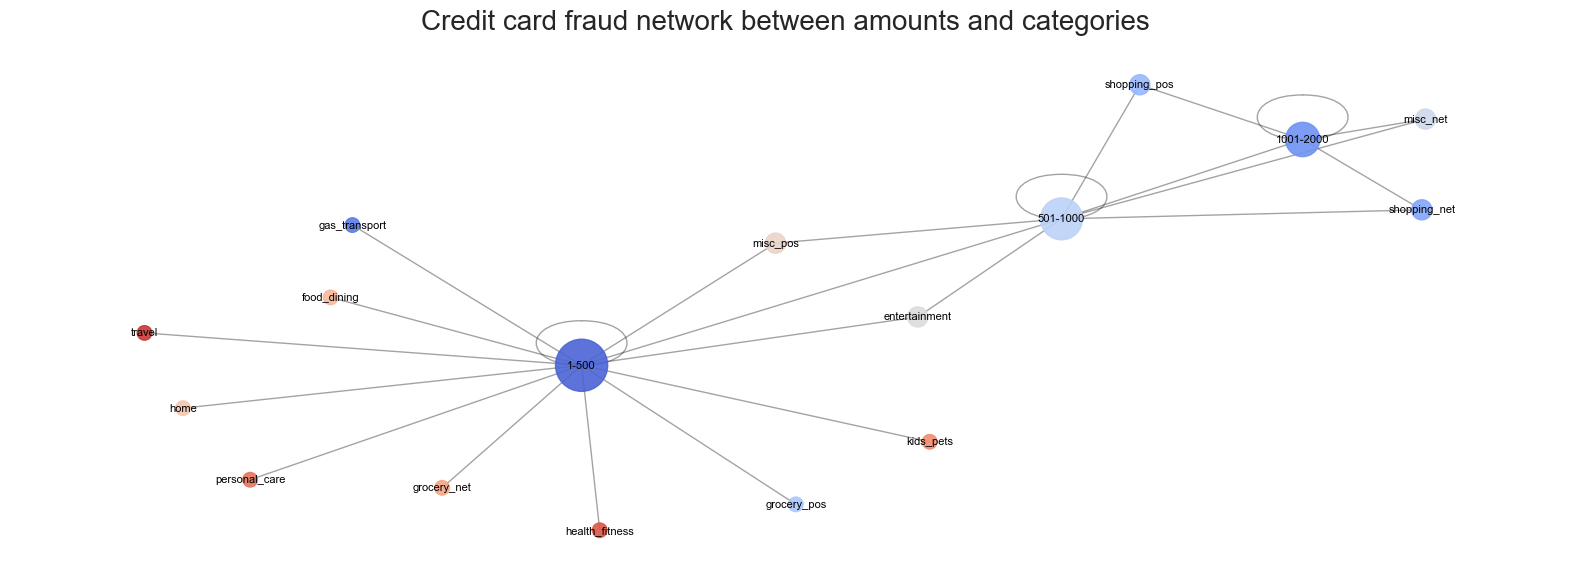

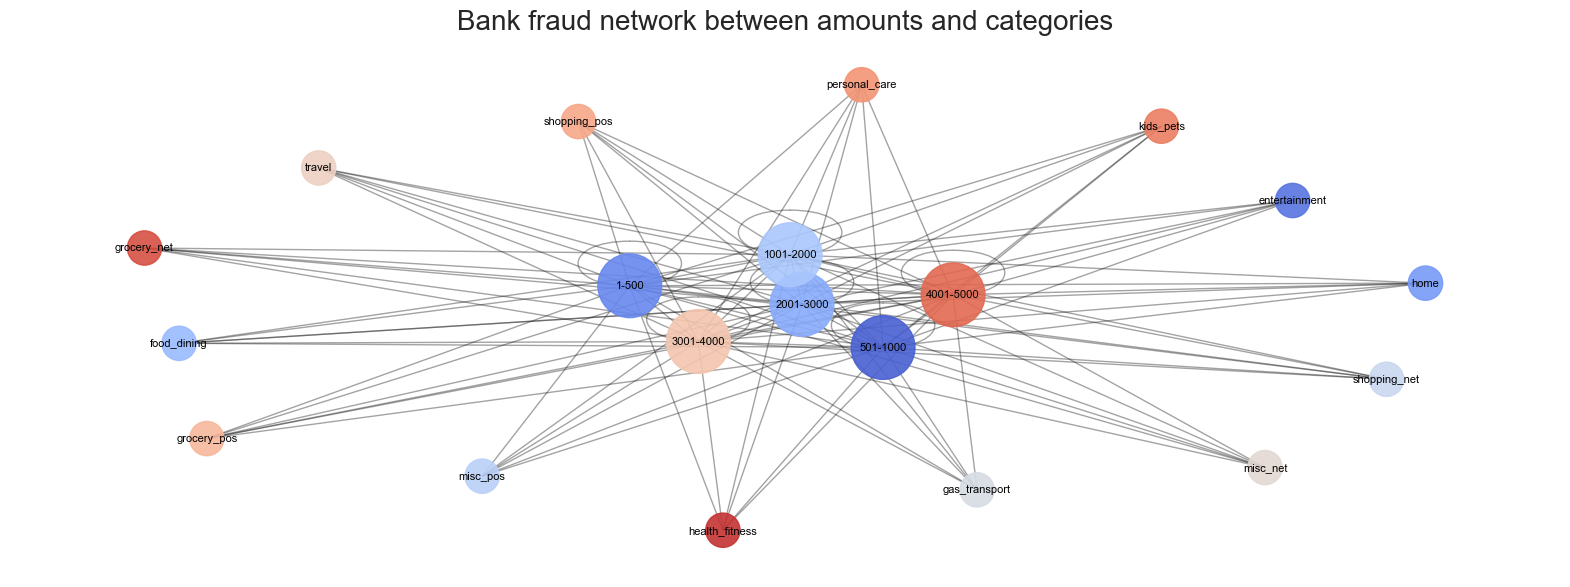

In [8]:
# building the matrices
cc_fraud_edges = build_network_matrix(cc_fraud, 'amt_category','category')
b_fraud_edges = build_network_matrix(b_fraud, 'amt_category','category')

# credit card graph
cc_graph = nx.Graph()
cc_graph.add_edges_from(cc_fraud_edges)

# bank graph
b_graph = nx.Graph()
b_graph.add_edges_from(b_fraud_edges)

# draw graphs
draw_graph(cc_graph, 'Credit card fraud network between amounts and categories')
draw_graph(b_graph, 'Bank fraud network between amounts and categories')

From the networks displayed it is obvious that higher amounts are involved in bank fraudulent activities rather that credit card ones.

In [9]:
measures_cc = compute_graph_measures(cc_graph)

# measures of credit card
print("Credit card measures:")
print("Degree Centrality:", measures_cc['degree_centrality'].head(), "\n")
print("Betweenness Centrality:", measures_cc['betweenness_centrality'].head(), "\n")
print("Clustering Coefficient:", measures_cc['clustering_coefficient'].head(), "\n")

Credit card measures:
Degree Centrality:            degree_centrality
1-500                 0.8750
501-1000              0.5625
1001-2000             0.3750
misc_pos              0.1250
misc_net              0.1250 

Betweenness Centrality:                 betweenness_centrality
1-500                         0.829167
501-1000                      0.416667
1001-2000                     0.012500
home                          0.000000
health_fitness                0.000000 

Clustering Coefficient:                clustering_coefficient
entertainment                     1.0
misc_net                          1.0
shopping_net                      1.0
shopping_pos                      1.0
misc_pos                          1.0 



In [10]:
measures_b = compute_graph_measures(b_graph)

# measures of bank
print("Bank measures:")
print("Degree Centrality:", measures_b['degree_centrality'].head(), "\n")
print("Betweenness Centrality:", measures_b['betweenness_centrality'].head(), "\n")
print("Clustering Coefficient:", measures_b['clustering_coefficient'].head(), "\n")

Bank measures:
Degree Centrality:            degree_centrality
501-1000            1.105263
3001-4000           1.105263
1-500               1.105263
2001-3000           1.105263
4001-5000           1.105263 

Betweenness Centrality:            betweenness_centrality
501-1000                 0.088694
3001-4000                0.088694
1-500                    0.088694
2001-3000                0.088694
4001-5000                0.088694 

Clustering Coefficient:                clustering_coefficient
misc_net                          1.0
gas_transport                     1.0
grocery_net                       1.0
kids_pets                         1.0
personal_care                     1.0 



Based on the measures of both networks, the number of direct conections and how often a node appears that are measured by degree and betweenness centralities seem to vary a lot between credit card and bank fraud having higher values for bank transactions, and different patterns are seen also between tightly clustered nodes with their neighbors between both types of transactions.

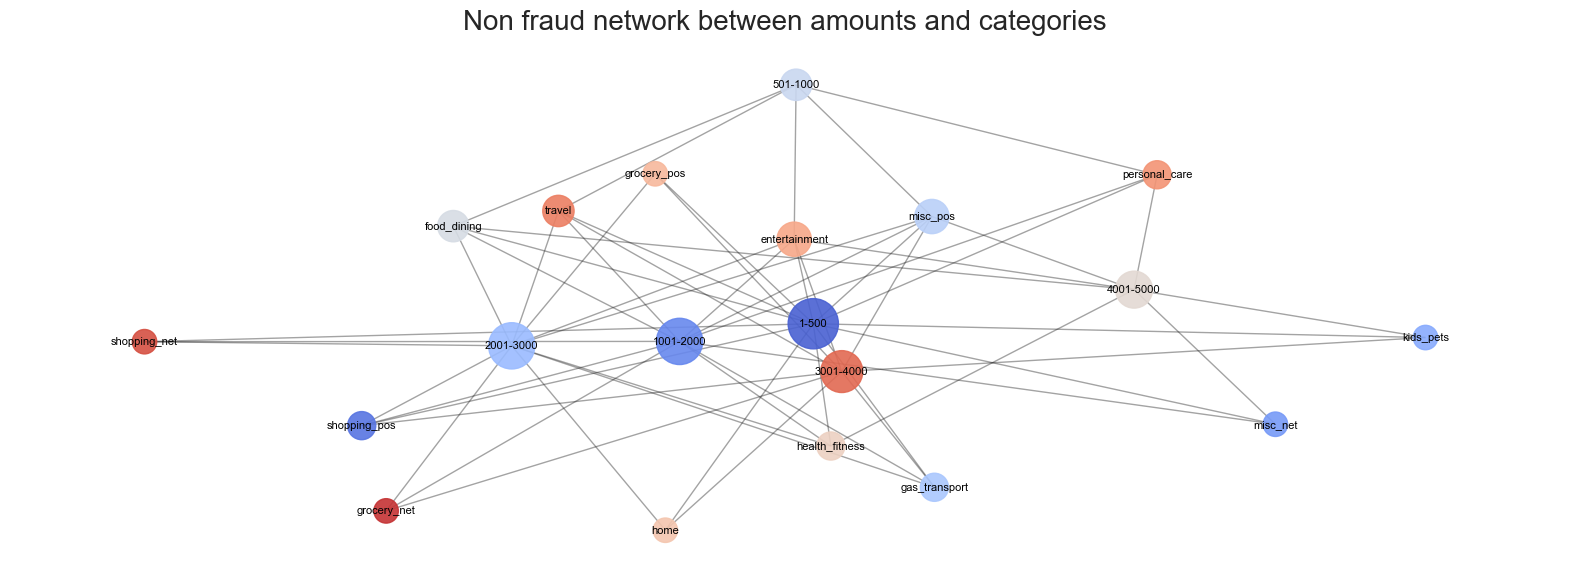

Non fraud measures:
Degree Centrality:            degree_centrality
1-500               0.684211
2001-3000           0.578947
1001-2000           0.578947
3001-4000           0.473684
4001-5000           0.368421 

Betweenness Centrality:            betweenness_centrality
1-500                    0.238136
1001-2000                0.149648
2001-3000                0.141849
3001-4000                0.097404
4001-5000                0.052075 

Clustering Coefficient:               clustering_coefficient
1-500                              0
shopping_pos                       0
shopping_net                       0
3001-4000                          0
travel                             0 



In [11]:
# building the matrices
non_fraud_edges = build_network_matrix(df_non_fraud, 'amt_category','category')

# credit card graph
non_graph = nx.Graph()
non_graph.add_edges_from(non_fraud_edges[:150])

# draw graphs
draw_graph(non_graph, 'Non fraud network between amounts and categories')

measures_non = compute_graph_measures(non_graph)

# measures of bank
print("Non fraud measures:")
print("Degree Centrality:", measures_non['degree_centrality'].head(), "\n")
print("Betweenness Centrality:", measures_non['betweenness_centrality'].head(), "\n")
print("Clustering Coefficient:", measures_non['clustering_coefficient'].head(), "\n")

From the above network and measures, we can notice that the non fraud transactions were not biased toward a specific category or amount but were distributed fairly.

### Category vs customer names networks

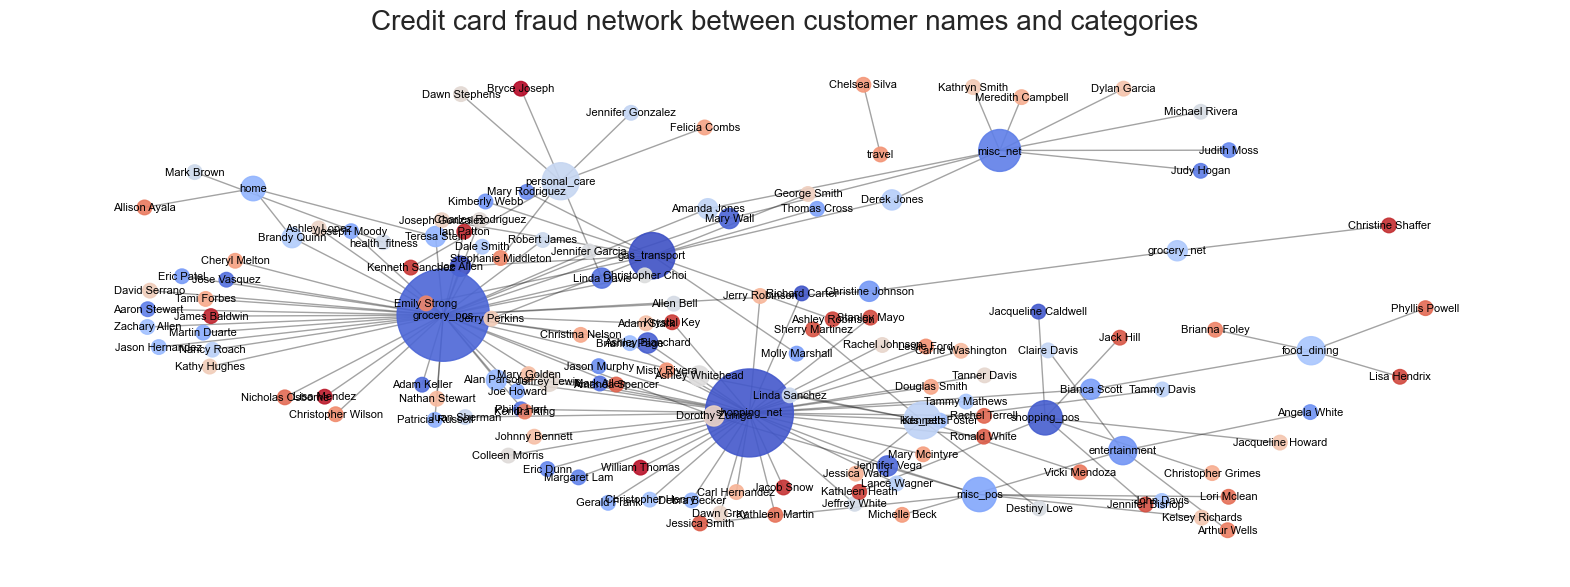

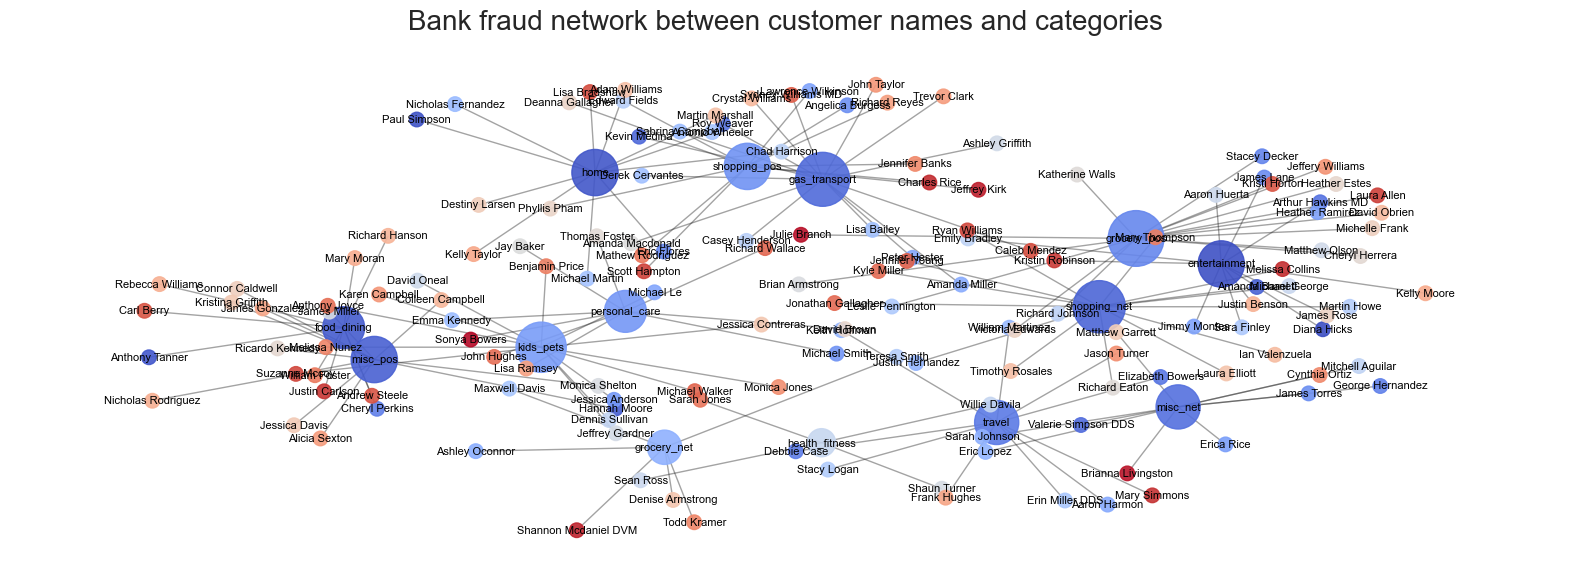

In [12]:
# building the matrices
cc_fraud_edges = build_network_matrix(cc_fraud, 'customer_name','category')
b_fraud_edges = build_network_matrix(b_fraud, 'customer_name','category')

# credit card graph
cc_graph = nx.Graph()
cc_graph.add_edges_from(cc_fraud_edges[:150])

# bank graph
b_graph = nx.Graph()
b_graph.add_edges_from(b_fraud_edges[:150])

# draw graphs
draw_graph(cc_graph, 'Credit card fraud network between customer names and categories')
draw_graph(b_graph, 'Bank fraud network between customer names and categories')

From those networks we can notice some main categories of fraud between both credit card and bank transactions, some of those categories are shopping, grocery, and misc_net that appear clearly in the displayed portion of our data.

In [13]:
measures_cc = compute_graph_measures(cc_graph)

# measures of credit card
print("Credit card measures:")
print("Degree Centrality:", measures_cc['degree_centrality'].head(), "\n")
print("Betweenness Centrality:", measures_cc['betweenness_centrality'].head(), "\n")
print("Clustering Coefficient:", measures_cc['clustering_coefficient'].head(), "\n")

Credit card measures:
Degree Centrality:                degree_centrality
grocery_pos             0.307692
shopping_net            0.279720
gas_transport           0.076923
misc_net                0.062937
personal_care           0.048951 

Betweenness Centrality:                betweenness_centrality
grocery_pos                  0.641329
shopping_net                 0.425465
gas_transport                0.111987
Joe Allen                    0.109885
Jeffrey Lewis                0.106553 

Clustering Coefficient:                    clustering_coefficient
Joe Allen                               0
gas_transport                           0
Johnny Bennett                          0
Mary Golden                             0
Carrie Washington                       0 



In [14]:
measures_b = compute_graph_measures(b_graph)

# measures of bank
print("Bank measures:")
print("Degree Centrality:", measures_b['degree_centrality'].head(), "\n")
print("Betweenness Centrality:", measures_b['betweenness_centrality'].head(), "\n")
print("Clustering Coefficient:", measures_b['clustering_coefficient'].head(), "\n")

Bank measures:
Degree Centrality:                degree_centrality
grocery_pos             0.098160
gas_transport           0.092025
shopping_net            0.085890
kids_pets               0.079755
home                    0.067485 

Betweenness Centrality:                betweenness_centrality
grocery_pos                  0.009089
gas_transport                0.007953
shopping_net                 0.006892
kids_pets                    0.005908
home                         0.004166 

Clustering Coefficient:                  clustering_coefficient
Diana Hicks                           0
Martin Marshall                       0
Timothy Rosales                       0
Ian Valenzuela                        0
David Obrien                          0 



After analyzing the measures, we can notice that both credit card and bank fraud transactions has the most transactions in 3 categories being grocery, gas transport, and shopping having the most direct connections and appearances according to degree and betweenness centralities. However it is remarkable that both of them have 0 clustering coefficients means having distinct customers.

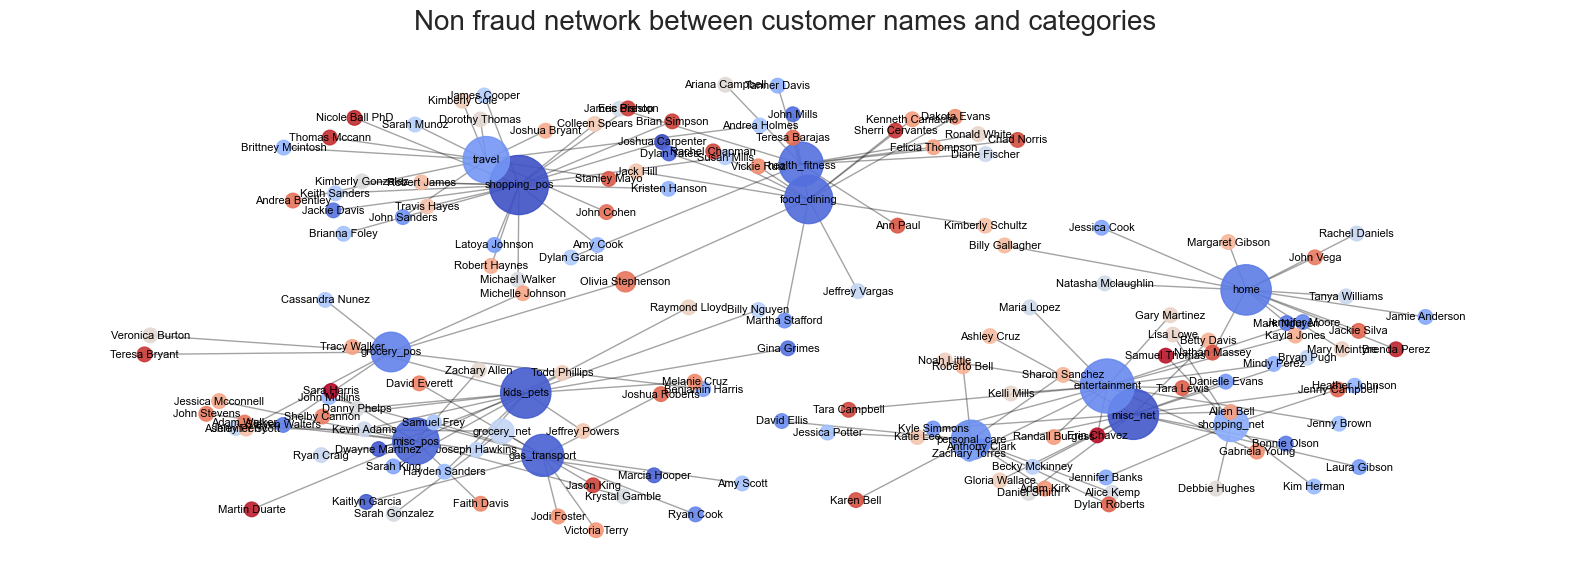

Non fraud measures:
Degree Centrality:                degree_centrality
shopping_pos            0.111111
entertainment           0.092593
misc_net                0.080247
home                    0.080247
kids_pets               0.080247 

Betweenness Centrality:                    betweenness_centrality
food_dining                      0.011809
shopping_pos                     0.011732
grocery_pos                      0.008588
entertainment                    0.008052
Olivia Stephenson                0.007361 

Clustering Coefficient:                   clustering_coefficient
Joshua Carpenter                       0
Victoria Terry                         0
Kimberly Schultz                       0
Robert James                           0
Ashley Cruz                            0 



In [15]:
# building the matrices
non_fraud_edges = build_network_matrix(df_non_fraud, 'customer_name','category')

# credit card graph
non_graph = nx.Graph()
non_graph.add_edges_from(non_fraud_edges[:150])

# draw graphs
draw_graph(non_graph, 'Non fraud network between customer names and categories')

measures_non = compute_graph_measures(non_graph)

# measures of bank
print("Non fraud measures:")
print("Degree Centrality:", measures_non['degree_centrality'].head(), "\n")
print("Betweenness Centrality:", measures_non['betweenness_centrality'].head(), "\n")
print("Clustering Coefficient:", measures_non['clustering_coefficient'].head(), "\n")

In the non fraud transactions, we can notice that the categories who have direct connections differ from the ones that appeared the most as revealed by the measures and those categories don't have same distribution with fraud transactions, while having 0 clustering coefficients due to the same reasin that is distinct customers.

### Category vs merchants networks

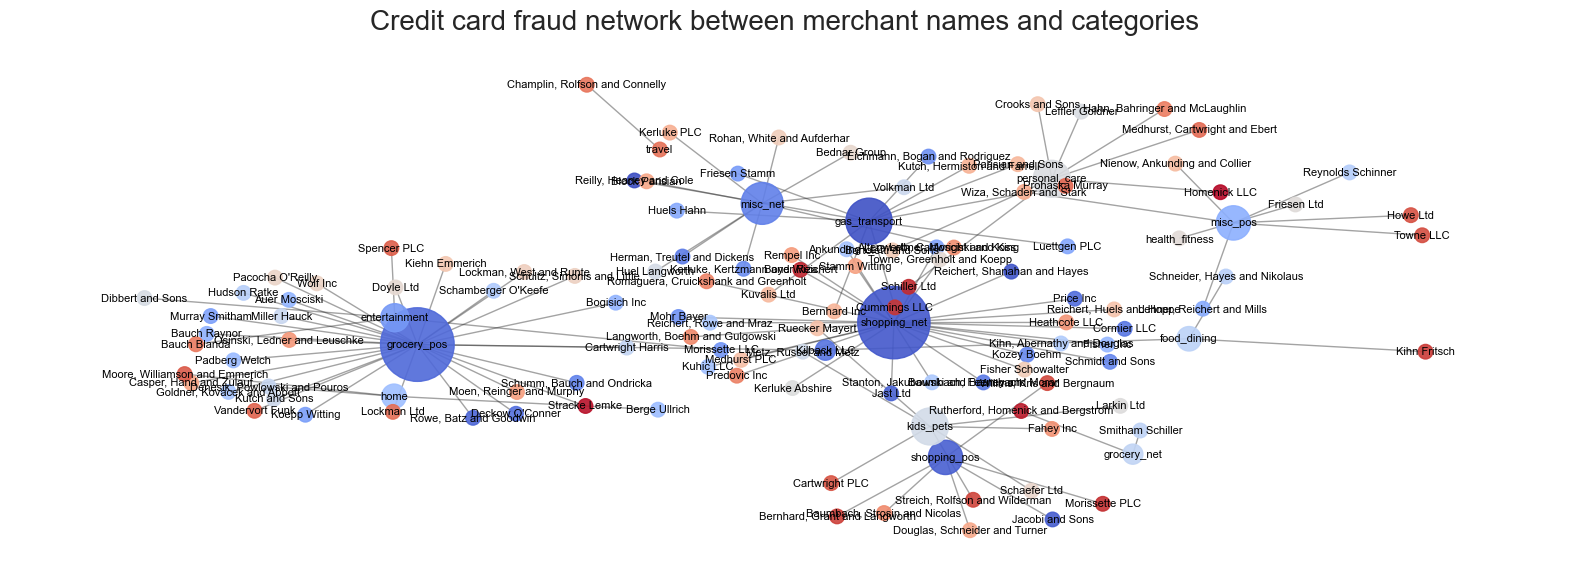

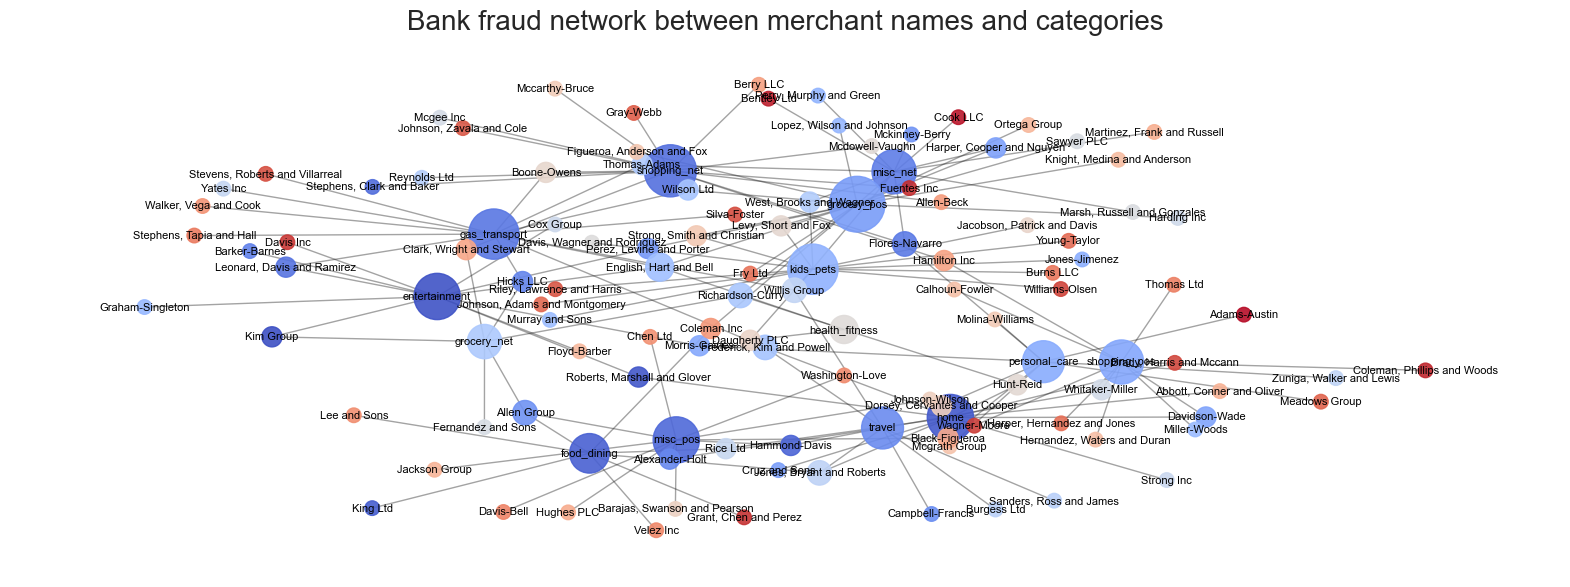

In [16]:
# building the matrices
cc_fraud_edges = build_network_matrix(cc_fraud, 'merchant','category')
b_fraud_edges = build_network_matrix(b_fraud, 'merchant','category')

# credit card graph
cc_graph = nx.Graph()
cc_graph.add_edges_from(cc_fraud_edges[:150])

# bank graph
b_graph = nx.Graph()
b_graph.add_edges_from(b_fraud_edges[:150])

# draw graphs
draw_graph(cc_graph, 'Credit card fraud network between merchant names and categories')
draw_graph(b_graph, 'Bank fraud network between merchant names and categories')

From those networks that display the relation between categories and merchants we can notice that they follow similar patterns as customers names as grocery, shopping, and misc_net have the highest connections in the dislayed portion of our data while better insights will be revealed by the different measures to be calculated.

In [17]:
measures_cc = compute_graph_measures(cc_graph)

# measures of credit card
print("Credit card measures:")
print("Degree Centrality:", measures_cc['degree_centrality'].head(), "\n")
print("Betweenness Centrality:", measures_cc['betweenness_centrality'].head(), "\n")
print("Clustering Coefficient:", measures_cc['clustering_coefficient'].head(), "\n")

Credit card measures:
Degree Centrality:                degree_centrality
grocery_pos             0.220472
shopping_net            0.212598
gas_transport           0.086614
misc_net                0.070866
personal_care           0.055118 

Betweenness Centrality:                betweenness_centrality
grocery_pos                  0.057368
shopping_net                 0.043870
Kilback LLC                  0.010499
food_dining                  0.007374
gas_transport                0.006874 

Clustering Coefficient:                           clustering_coefficient
Reilly, Heaney and Cole                        0
gas_transport                                  0
Moen, Reinger and Murphy                       0
Stamm Witting                                  0
Casper, Hand and Zulauf                        0 



In [18]:
measures_b = compute_graph_measures(b_graph)

# measures of bank
print("Bank measures:")
print("Degree Centrality:", measures_b['degree_centrality'].head(), "\n")
print("Betweenness Centrality:", measures_b['betweenness_centrality'].head(), "\n")
print("Clustering Coefficient:", measures_b['clustering_coefficient'].head(), "\n")

Bank measures:
Degree Centrality:                degree_centrality
grocery_pos             0.135593
shopping_net            0.118644
kids_pets               0.110169
gas_transport           0.110169
home                    0.093220 

Betweenness Centrality:                betweenness_centrality
grocery_pos                  0.237863
shopping_net                 0.210689
gas_transport                0.206099
misc_net                     0.194575
home                         0.170064 

Clustering Coefficient:                            clustering_coefficient
Kim Group                                       0
Calhoun-Fowler                                  0
Berry LLC                                       0
Hamilton Inc                                    0
Clark, Wright and Stewart                       0 



As previously mentioned the dominant fraud categories are grocery, shopping, and gas transport in both types of transactions.

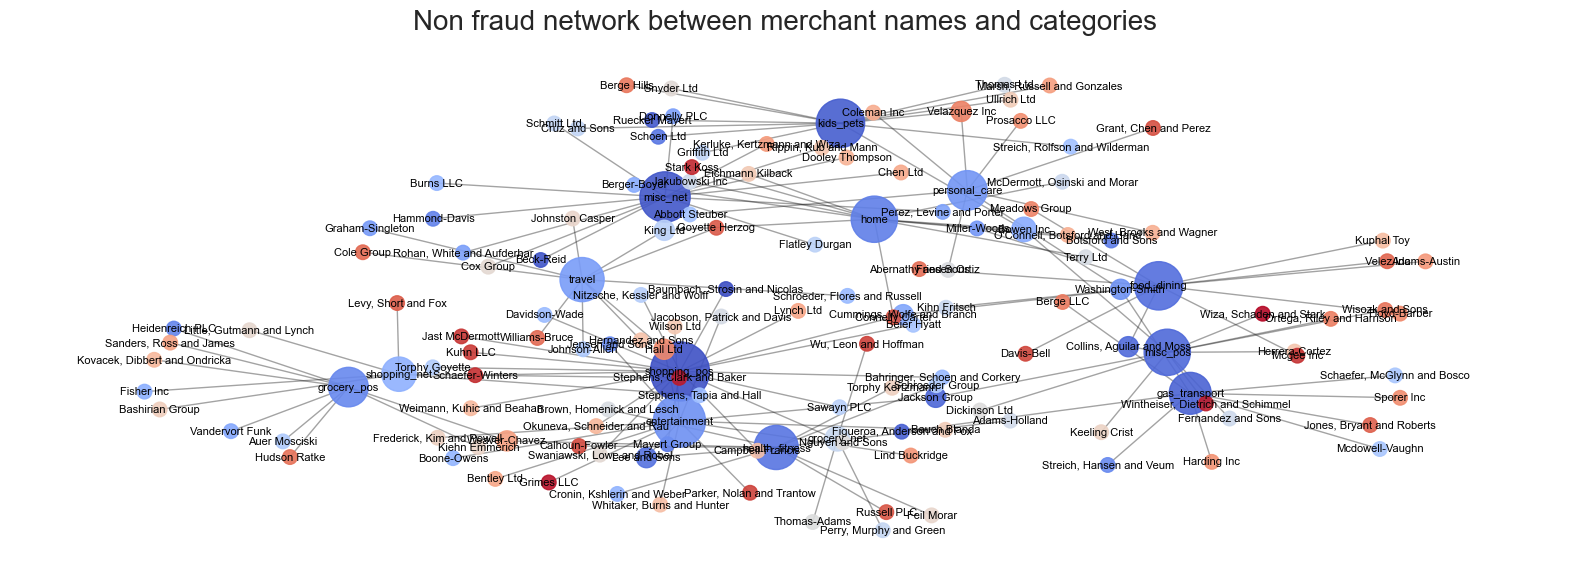

Non fraud measures:
Degree Centrality:                degree_centrality
shopping_pos            0.122449
entertainment           0.095238
misc_net                0.088435
kids_pets               0.081633
food_dining             0.081633 

Betweenness Centrality:                betweenness_centrality
misc_pos                     0.433650
Bowen Inc                    0.324527
entertainment                0.304678
food_dining                  0.273227
kids_pets                    0.266238 

Clustering Coefficient:                                clustering_coefficient
Baumbach, Strosin and Nicolas                       0
Hernandez and Sons                                  0
Whitaker, Burns and Hunter                          0
Kuphal Toy                                          0
Weimann, Kuhic and Beahan                           0 



In [19]:
# building the matrices
non_fraud_edges = build_network_matrix(df_non_fraud, 'merchant','category')

# credit card graph
non_graph = nx.Graph()
non_graph.add_edges_from(non_fraud_edges[:150])

# draw graphs
draw_graph(non_graph, 'Non fraud network between merchant names and categories')

measures_non = compute_graph_measures(non_graph)

# measures of bank
print("Non fraud measures:")
print("Degree Centrality:", measures_non['degree_centrality'].head(), "\n")
print("Betweenness Centrality:", measures_non['betweenness_centrality'].head(), "\n")
print("Clustering Coefficient:", measures_non['clustering_coefficient'].head(), "\n")

Concerning merchant names, the categories who have much direct connections differ from those who appeared the most.

### Summary

Overall, the fraudulent activities were dominant in specific categories that are grocery, shopping, and gas transport. Credit card transactions had very clear dominance of those categories, while bank transactions had less dominance of them with some others sharing similar patterns.

On the other hand, non fraudulent transactions were distributed on different categories with no specific patterns to be noticed.